<a href="https://colab.research.google.com/github/shakir507/ABM_SynthPop/blob/master/ServiceBacklogModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The ideas in this model are based on Stermans book and Jim Duggans paper titled 'System dynamics modelling to support policy analysis
for sustainable health care'. The aim is to model backlogs in healthcare.

# The model

The model consists of backlog and resources as stock:
1. Backlog describing the que
2. Resources catering to the backlog.

There are auxilary variables that correspond to:
1. Input demand
2. Demand surge
3. Surge start and end
4. The time delay to process one patient in the healthcare system
5. Working hours in a day
6. Number of working days in a work week.
7. Productivity of each doctor.
8. Delay in hiring a resource/doctor
9. Attrition rate

Some variables are endogeneous:
10. Net Backlog dependent net hiring rate.


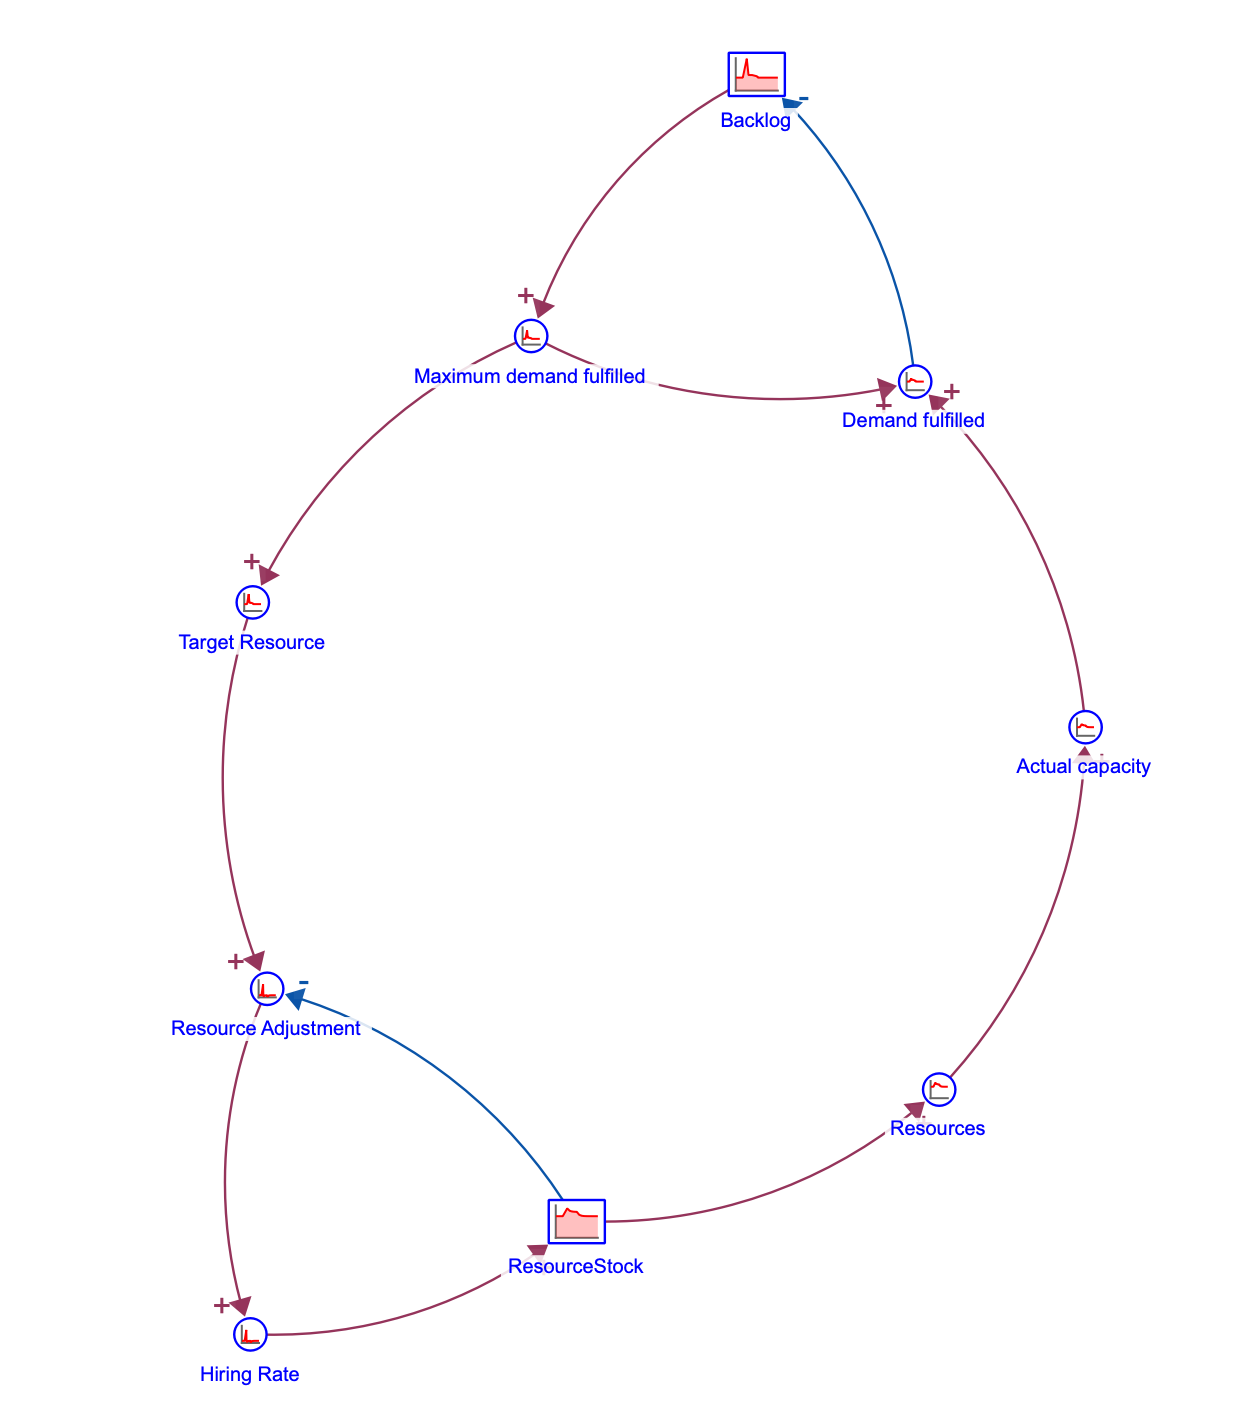
Fig 1: The CLD generated through Stella for service backlog model

The model equations are as follows:
1. B'=demand(t)-min(capacity, backlog/service delay)
2. R'= (Target resource - R)/hiring delay

# Python code
Simulation code in python

In [1]:
#Importing relevant libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [6]:
# Parameters and initial conditions
initial_backlog = 2  # Initial number of patients
R0=2    # Initial number of resources
time_span = (1, 20)  # Time range for simulation
time_points = np.linspace(time_span[0], time_span[1], 10000)  # Time points for evaluation
demandsurge=20 # counts of patient surge from a base background
Wd=5  # number of days in work week
Wh=10 # number of hours in a working day
deliverydelay=1/50 # Time to see a patient. It is 1 hour and is expressed in weeks i.e. 1 hour =1/50 weeks
RAT=1# Resource Allocation Time

#-------------------

In [3]:

# Define the time-dependent growth rate a(t)
def STEP(a0,t,t0):
    return a0*np.heaviside(t-t0,0)

def demand(t,delta, fn=1,period=5):
    t1=10
    t2=t1+period
    if fn==1:
        return 100 + STEP(delta,t,t1)- STEP(delta,t,t1+period)#Square wave demand surge
    if fn==2:
        #Sinusoidal demand surge
        return 100+(1 + delta*np.sin(2*np.pi*t/(2*period)))*STEP(1,t,t1)-(1 + delta*np.sin(2*np.pi*t/(2*period)))*STEP(1,t,t1+period)
    # Using Heaviside for step functions

In [5]:
# defining hiring and leaving rate functions
def hiring(t,sp,Cp):

    return Cp*(1+sp)

def attrition(t,sp,Cp):

    return Cp

In [4]:

# Define the ODE for customer growth
def backloghospital(t, Y, demandsurge):
    B, R = Y
    a = demand(t,demandsurge,2)  # Get the time-dependent growth rate
    MaximumDemandFullfilled=B/deliverydelay
    C0=R*Wd*Wh
    C=C0
    Cp=MaximumDemandFullfilled
    dCp=Cp-C #Difference between required capacity and current capacity
    sp=dCp/C#Schedule Pressure


    d=min(MaximumDemandFullfilled,C) #Demand met
    dB_dt = a - d #Change in backlog based on demand met and demand and demand surge
    hr=hiring(t,sp,Cp)
    at=attrition(t,sp,Cp)
    dR_dt=hr-at
    if t>=10 and t<=15:
        print("t=",t,"B=",B,"a=",a,"dG_dt=",dB_dt,"declinefraction=",d)
    return [dB_dt,dR_dt]

In [7]:

# Solve the ODE
solution = solve_ivp(
    backloghospital,          # ODE function
    time_span,                # Time span
    [initial_backlog,2],      # Initial condition
    t_eval=time_points,       # Time points to evaluate the solution
    args=(demandsurge,),  # Additional arguments for the ODE function
    rtol=1e-20,  # Reduce relative tolerance
    atol=1e-20   # Reduce absolute tolerance
)


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Streaming output truncated to the last 5000 lines.
t= 13.91195133528359 B= 2.27650450665961 a= 113.63240198780646 dG_dt= -0.192823345174034 declinefraction= 113.8252253329805
t= 13.912528889459205 B= 2.2763931244687545 a= 113.62677437430523 dG_dt= -0.1928818491324904 declinefraction= 113.81965622343772
t= 13.912631565757094 B= 2.2763733207940215 a= 113.62577373558165 dG_dt= -0.19289230411942526 declinefraction= 113.81866603970107
t= 13.912759911129452 B= 2.2763485630146123 a= 113.62452286328178 dG_dt= -0.19290528744882351 declinefraction= 113.8174281507306
t= 13.912759911129452 B= 2.2763485612976773 a= 113.62452286328178 dG_dt= -0.19290520160207336 declinefraction= 113.81742806488386
t= 13.912990969908522 B= 2.2763039888573187 a= 113.62227072453678 dG_dt= -0.19292871832915637 declinefraction= 113.81519944286593
t= 13.913106499298058 B= 2.276281696524175 a= 113.62114455539738 dG_dt= -0.19294027081136278 declinefraction= 113.81408482620874
t= 13.913684146245735 B= 2.2761702289119743 a= 1

In [8]:

# Extract results
time = solution.t
backlog = solution.y[0]
# resources = solution.y[1]
inflow=backlog*np.array([demand(t,demandsurge) for t in time])


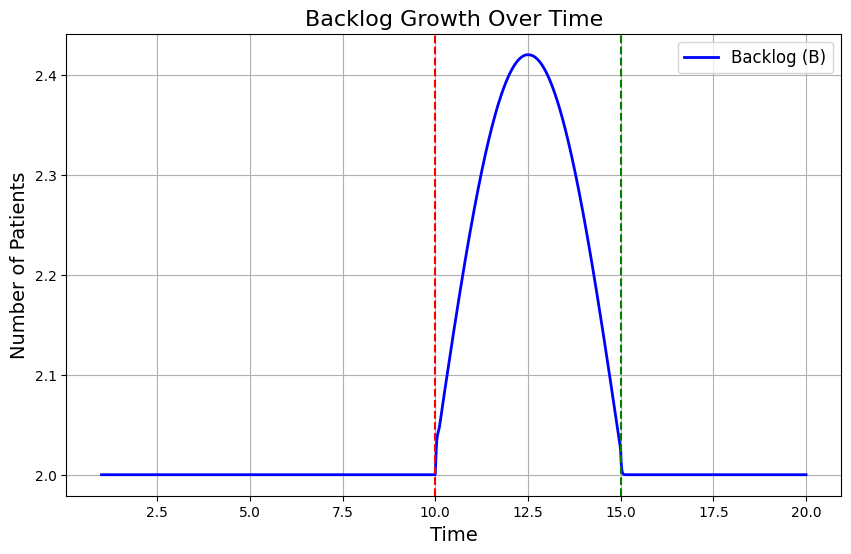

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time, backlog, label="Backlog (B)", color="blue", linewidth=2)
# plt.plot(time, resources, label="Resources (R)", color="green", linewidth=2)
plt.axvline(10, color="red", linestyle="--")
plt.axvline(15, color="green", linestyle="--")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Number of Patients", fontsize=14)
plt.title("Backlog Growth Over Time", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
# Save the plot into a png and jpg file
plt.savefig('./Backlog_Growth.png')
plt.savefig('./Backlog_Growth.jpg')
plt.show()